## Module 5 : Association Rule Mining and  Feature Embedding

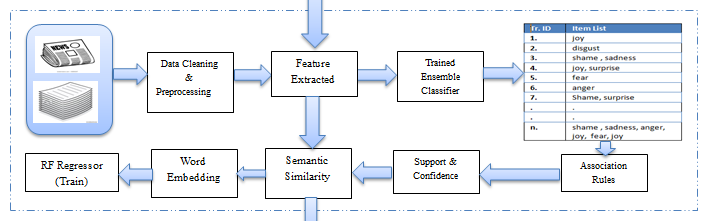

In [1]:
from PIL import Image
Image.open("arc_3.png")

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from nltk.tokenize import word_tokenize
import re
import nltk
#http://rasbt.github.io/mlxtend/
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import warnings 
warnings.filterwarnings("ignore")

import glob
from bs4  import  BeautifulSoup
from nltk.corpus import wordnet as wn

## 1. loading the saved output data

In [5]:
import pickle
with open('output_files/X_train', 'rb') as f:              # Opening X_train file for recreating input matrix
    x = pickle.load(f)
x.shape

(14568, 6450)

In [6]:
with open('output_files/y_train', 'rb') as f:              # Opening y_train file for recreating input matrix 
    y_train = pickle.load(f)
    
#y=y_train
ly = y_train.values.tolist()
len(ly)

14568

In [7]:
import pickle
with open('output_files/X_test', 'rb') as f:              # Opening X_train file for recreating input matrix
    X_test = pickle.load(f)
X_test.shape

(3643, 6450)

In [8]:
import pickle
with open('output_files/y_test', 'rb') as f:              # Opening y_test file for recreating input matrix
    y_test = pickle.load(f)
    
#y=y_test
yt = y_test.values.tolist()
len(yt)

3643

In [9]:
with open('output_files/features', 'rb') as f:              # Opening feature file for recreating input matrix
    new_features = pickle.load(f)

## 2. Loading article and headline data 

In [57]:
headline_pred = pd.read_csv("output_files/headline_predicted.txt",delimiter = "\t" , index_col=False, header = None)
headline_pred.columns = ["Transaction_ID", "Item_list"]
print (headline_pred.head(10))

   Transaction_ID   Item_list
0               1      joy   
1               2  sadness   
2               3      joy   
3               4      joy   
4               5  sadness   
5               6    shame   
6               7    shame   
7               8      joy   
8               9     fear   
9              10      joy   


In [58]:
headline_pred.shape

(200849, 2)

In [59]:
article_pred = pd.read_csv("output_files/article_predicted.txt",delimiter = "\t" ,index_col=False, header = None)
article_pred.columns = ["Transaction_ID", "Item_list"]
print (article_pred.head(10))

   Transaction_ID                                          Item_list
0           12001  joy guilt sadness guilt sadness joy guilt guil...
1           12002         joy sadness joy guilt fear joy joy fear   
2           12003          fear sadness guilt joy guilt guilt joy   
3           12004                                         disgust   
4           12005  sadness shame joy joy guilt joy sadness shame ...
5           12006  joy sadness joy shame guilt shame guilt shame ...
6           12007  joy joy sadness joy joy sadness sadness joy fe...
7           12008  joy sadness shame sadness anger joy guilt sadn...
8           12009  sadness sadness sadness joy disgust shame sadn...
9           12010  sadness sadness joy joy joy guilt shame disgus...


In [60]:
article_pred.shape

(16252, 2)

In [61]:
merge_data = pd.concat([headline_pred , article_pred ],ignore_index=True, sort=False)

In [62]:
merge_data.head() , merge_data.shape

(   Transaction_ID   Item_list
 0               1      joy   
 1               2  sadness   
 2               3      joy   
 3               4      joy   
 4               5  sadness   , (217101, 2))

In [63]:
# standard emotion list
emotions = ['joy', 'fear', 'anger', 'sadness', 'disgust', 'shame', 'guilt']

In [ ]:
new_data = pd.DataFrame(columns = emotions)
new_data 

In [ ]:
# placing 1 or 0 acording to the emotion list and item list set i.e. making the dataset ready for AR Rules
col = new_data.shape[1]            # Initialize column length i.e. number of emotions = 7
row = len(merge_data["Item_list"])       # initialize row lengh 

for i in range(0,row):                   # first loop start with range of row
    new_data.loc[i]=list([0] * col)      # initialize new_data' row with '0'
    itm_lst = merge_data["Item_list"][i]       
    # itm_lst can be 1 (headline data predicted labeles) and more than 1 (paragrpahs grouped labels)
    if len(itm_lst) == 1:                            
        for emo in emotions:            # checked single value of itm_lst with all emoions 
            if itm_lst == emo :
                x = new_data.columns.get_loc(itm_lst)   # If itm_lst is equal emo then find the index of itm_lst in new_data 
                new_data.iat[i, x] = 1                  # replace '0' with '1' on above found index
    else:
        emo_set = itm_lst.split()      # spli if more than 1 value
        for j in range(0,col):         
            for val in emo_set:
                #print(val)
                for emo in emotions:
                    if val == emo:
                        x = new_data.columns.get_loc(val)
                        new_data.iat[i, x] = 1

In [ ]:
#saving Features file for future use
import pickle
with open('output_files/new_data', 'wb') as f:
    pickle.dump(new_data, f)

In [64]:
import pickle
with open('output_files/new_data', 'rb') as f:              # Opening X_train file for recreating input matrix
    new_data = pickle.load(f)

In [65]:
new_data.shape

(217101, 7)

In [67]:
new_data.head(10)

,joy,fear,anger,sadness,disgust,shame,guilt
0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0
5,0,0,0,0,0,1,0
6,0,0,0,0,0,1,0
7,1,0,0,0,0,0,0
8,0,1,0,0,0,0,0
9,1,0,0,0,0,0,0


## 3. Applying Apriori Algorithm

In [68]:
freq_items = apriori(new_data, min_support=0.003, use_colnames=True)

In [69]:
freq_items

,support,itemsets
0,0.369455,(joy)
1,0.112828,(fear)
2,0.094988,(anger)
3,0.192505,(sadness)
4,0.151777,(disgust)
...,...,...
122,0.0118516,"(joy, disgust, guilt, anger, shame, fear)"
123,0.0142791,"(joy, disgust, guilt, shame, sadness, fear)"
124,0.0153938,"(joy, disgust, guilt, anger, shame, sadness)"
125,0.011672,"(disgust, guilt, anger, shame, sadness, fear)"


## 4. Applying Association Rule Mining

In [16]:
association_rules = association_rules(freq_items, min_threshold=0.1, support_only=False)

In [17]:
#saving X_train file for future use
import pickle
with open('output_files/association_rules', 'wb') as f:
    pickle.dump(association_rules, f)

In [2]:
import pickle
with open('output_files/association_rules', 'rb') as f:      # Opening association rule file for recreating input matrix 
    association_rules = pickle.load(f)

In [10]:
association_rules 

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(fear),(joy),0.112828,0.369455,0.029498,0.261441,0.707640,-0.012187,0.853751
1,(anger),(joy),0.094988,0.369455,0.030539,0.321501,0.870205,-0.004555,0.929324
2,(joy),(sadness),0.369455,0.192505,0.056605,0.153212,0.795888,-0.014517,0.953598
3,(sadness),(joy),0.192505,0.369455,0.056605,0.294044,0.795888,-0.014517,0.893180
4,(disgust),(joy),0.151777,0.369455,0.034961,0.230342,0.623465,-0.021114,0.819254
...,...,...,...,...,...,...,...,...,...
1769,"(sadness, disgust)","(fear, guilt, shame, anger, joy)",0.032962,0.014049,0.011598,0.351873,25.046519,0.011135,1.521231
1770,"(disgust, anger)","(fear, guilt, sadness, shame, joy)",0.020986,0.017955,0.011598,0.552678,30.781657,0.011221,2.195387
1771,"(sadness, anger)","(fear, guilt, shame, joy, disgust)",0.028719,0.014754,0.011598,0.403849,27.373111,0.011175,1.652680
1772,(fear),"(guilt, sadness, shame, anger, joy, disgust)",0.112828,0.015394,0.011598,0.102796,6.677804,0.009861,1.097417


## 5. New Y_train calculation from confidence value

In [3]:
ar_consequents = association_rules['consequents']
ar_support = association_rules['support']
ar_confidence = association_rules['confidence']

In [10]:
# if antecedents and consequents emotions are same , find the support and confidence value and replace Y_train 
# values with repective support and confidence.

new_target=np.zeros((len(x)))                        # creating new target 
feature_dict = dict.fromkeys(new_features,0.0)           # creating feature dict with all features as keys and values initliaze 0.0

with open("output_files/AssoSupCon.txt", "a+") as oput:           # creating new file
    for ix in range(len(x[0])):                                   # goes upto len(X_train)
        ind = [i for i, val in enumerate(x[:,ix]) if val]         # if there is value then gets index of it
        if len(ind)>0:                                            # checking for empty index list
            oput.write(f'{ix} ')                                  # writes index
            li={ly[ix]}                                           
            lx=frozenset(li)                                      # converting into frozenset of y_train label with given index
            oput.write(f' {lx} ')
            fList=[]
            for l in ind:                                         
                li={ly[l]}                                         # loops goes for len of index list, it checks for frozenset value
                if li==lx:                                         # with each y train label if its not in resultant list
                    continue                                       # then appends function add ytrain label to flist.
                if ly[l] in fList:
                    continue
                fList.append(ly[l])
            fl=frozenset(fList)
            oput.write(f' {fl}  \n')
            
            ara=association_rules.index[association_rules["antecedents"] == li ] #retrieves ar_rules for antecedents for given label
            for a in ara:
                if fl==ar_consequents[a]:                        # retrieveing consequents values for antecedents rules
                    sup=ar_support[a]                            # retrieveng values of support and confidence       
                    conf=ar_confidence[a]        
                    new_target[l]= conf                  # filling up new confidence values for new_target 
                    print(conf)
                
                    if feature_dict[new_features[ix]] > sup :       # filling the value of feature with greater support.
                        pass
                    else:
                        feature_dict[new_features[ix]] = sup
oput.close()

0.3023470080496557
0.12485033524904214
0.1591019299776937
0.1897488119484046
0.27469468390804597
0.1897488119484046
0.18424168197591345
0.22219228927203064
0.20749684802637958
0.12348988268149459
0.11119541136839549
0.1911929835209857
0.1297824994616323
0.11693120087402507
0.10798459072093414
0.1369411308311512
0.13529179691056417
0.2171709508057419
0.14790030064979148
0.22914880587875078
0.17122484626612114
0.10279648907940396
0.15974688711982035
0.14958154725454173
0.1228784792939579
0.12907043792297654
0.16241954394276553
0.17564655172413793
0.19163094509083486
0.12791721040332615
0.14487547892720307
0.13430478788313832
0.12907043792297654
0.23841600326597265
0.10709587349316724
0.20318486590038315
0.1036278735632184
0.1897488119484046
0.16787896421297643
0.16938221317040056
0.1897488119484046
0.11599041000273135
0.10279648907940396
0.17564655172413793
0.19929121808467792
0.14918766300576652
0.17027964890794037
0.27412472117156433
0.10279648907940396
0.10851194121249234
0.1008542100

0.10788746927255623
0.138856820683545
0.1617689845795752
0.2161768984579575
0.1780826075081181
0.15177061239831394
0.12210260886431966
0.12549948555978274
0.1511941974446906
0.1280830938697318
0.14487547892720307
0.2171709508057419
0.18223256716128408
0.11248802681992338
0.14211063482343333
0.17362727087160643
0.2614411104307001
0.17564655172413793
0.12210260886431966
0.12907043792297654
0.13430478788313832
0.10279648907940396
0.13430478788313832
0.32150130928135
0.23887110852487634
0.26592745724487876
0.12348988268149459
0.11786662838274353
0.15177061239831394
0.15974688711982035
0.22219228927203064
0.10554399062043883
0.1897488119484046
0.1297824994616323
0.26748133061778684
0.13826590998755728
0.11786662838274353
0.11037414753955292
0.21114513165952237
0.19572655707893666
0.11120636864666258
0.22013255808388962
0.11880387931034483
0.2209291048394918
0.17564655172413793
0.20749684802637958
0.10573586446213512
0.15970606246172686
0.17564655172413793
0.12284907893538892
0.1277276694791

In [11]:
len(new_target)

14568

## 6. New Y_test Calculation from confidence value

In [12]:
# if antecedents and consequents emotions are same , find the support and confidence value and replace y_test 
# values with repective support and confidence.

new_test=np.zeros((len(X_test)))                        # creating new target 

with open("output_files/AssoSupCon1.txt", "a+") as oput:           # creating new file
    for ix in range(len(yt)):                                   # goes upto len(X_train)
        ind = [i for i, val in enumerate(X_test[:,ix]) if val]         # if there is value then gets index of it
        if len(ind)>0:                                            # checking for empty index list
            oput.write(f'{ix} ')                                  # writes index
            li={yt[ix]}                                           
            lx=frozenset(li)                                      # converting into frozenset of y_train label with given index
            oput.write(f' {lx} ')
    
            fList=[]
            for l in ind:                                         
                li={yt[l]}                                         # loops goes for len of index list, it checks for frozenset value
                if li==lx:                                         # with each y train label if its not in resultant list
                    continue                                       # then appends function add ytrain label to flist.
                if yt[l] in fList:
                    continue
                fList.append(yt[l])
            fl=frozenset(fList)
            oput.write(f' {fl}  \n')
            
            ara=association_rules.index[association_rules["antecedents"] == li ] #retrieves ar_rules for antecedents for given label
            for a in ara:
                if fl == ar_consequents[a]:                        # retrieveing consequents values for antecedents rules
                    sup = ar_support[a]                            # retrieveng values of support and confidence       
                    conf = ar_confidence[a]        
        
                    new_test[l]= conf                  # filling up new confidence values for new_target 
                    print(conf)
                    feature_dict[new_features[ix]] = sup
                    #print(sup)
oput.close()

0.1911929835209857
0.14592313218390807
0.16914113888366847
0.12214737701571748
0.16914113888366847
0.13826590998755728
0.1228784792939579
0.32150130928135
0.1780826075081181
0.1511941974446906
0.1380806992337165
0.11028162610963559
0.12210260886431966
0.1929819851263189
0.17362727087160643
0.15974688711982035
0.14456011430904267
0.15816570881226055
0.14693046261274367
0.1780826075081181
0.12348988268149459
0.14456011430904267
0.27412472117156433
0.15321223304117992
0.15321223304117992
0.13973631947933865
0.20846668606342741
0.14918766300576652
0.14487547892720307
0.21114513165952237
0.10788746927255623
0.10479525862068965
0.2562312093880322
0.25434002521578897
0.17027964890794037
0.16914113888366847
0.17362727087160643
0.1380806992337165
0.13940133515181968
0.1260665441926924
0.12907043792297654
0.22013255808388962
0.16938221317040056
0.27412472117156433
0.1511941974446906
0.2161768984579575
0.10279648907940396
0.2209291048394918
0.10961731055203179
0.14508777034235282
0.17122484626612

In [13]:
feature_dict

{'abandoned': 0.029018751640941313,
 'abdomen': 0.0,
 'abdominal': 0.0,
 'abide': 0.0,
 'abilities': 0.0,
 'ability': 0.0,
 'ablation': 0.0,
 'able': 0.0,
 'abnormal': 0.0,
 'aboout': 0.022454986388823636,
 'aboriginal': 0.0,
 'abortion': 0.029018751640941313,
 'aborts': 0.0,
 'abou': 0.0,
 'abour': 0.0,
 'aboutthe': 0.013781603953920064,
 'abroad': 0.0,
 'abrupt': 0.0,
 'abruptly': 0.0,
 'abscence': 0.028719351822423664,
 'absence': 0.0,
 'absent': 0.0,
 'absolutely': 0.0,
 'abuse': 0.0,
 'abused': 0.0,
 'abusing': 0.0,
 'abusive': 0.0,
 'abut': 0.0,
 'academic': 0.0,
 'academically': 0.0,
 'academics': 0.0,
 'acccident': 0.0,
 'acccused': 0.0,
 'accelerating': 0.019212256046724795,
 'accent': 0.0,
 'accept': 0.0,
 'acceptable': 0.0,
 'acceptance': 0.0,
 'accepted': 0.0,
 'accepting': 0.0,
 'accepts': 0.015112781608560071,
 'accident': 0.0,
 'accidentally': 0.029018751640941313,
 'acclaim': 0.0,
 'accomodation': 0.0,
 'accompanied': 0.0,
 'accompanying': 0.018023869074762437,
 'accomp

## 7. New X_train and X_test Feature Embedding

### 7.1 Feature dict values before semantic similarity

In [20]:
valued_feature = []
empty_feature = []
for key,val in feature_dict.items():
    if feature_dict[key] != 0.0 :
        valued_feature.append(key)
    else:
        empty_feature.append(key)

In [21]:
len(valued_feature) , len(empty_feature)

(670, 5780)

### 7.2 Semantic Similarity between features 

In [3]:
# sample example : similarity between two words
a = wn.synsets('fear') 
b = wn.synsets('terror') 
x = a[0]
y = b[0]
similarity=x.wup_similarity(y)
print(similarity)

0.9333333333333333


Observation : It indicate 'fear' and 'terror' words are 93% similar

In [19]:
def getSimilarity(empty_feature,valued_feature):
    
    for a in empty_feature:
        x=wn.synsets(a)                         # interfacing to search the corpus feature in the wordnet 
        sim=0.0                                 # initialize the similarity variable 
        #print("x",x)
        for b in valued_feature:
            y=wn.synsets(b)                      # interfacing to search the corpus feature in the wordnet      
            #print("y",y)
            
            if (len(x)!=0) and (len(y)!=0):      # checking for empty list
                ai=x[0]                          # initialize with the synsets name for x        
                bi=y[0]                          # initialize with the synsets name for y
                similarity=ai.wup_similarity(bi) # Return a score denoting how similar two word senses are
                if similarity is None:            # checking for no similarity at all
                    similarity=0
                if similarity>sim:                # checking if similarity is more than similarity variable
                    sim=similarity 
                    if feature_dict[a] == 0.0 or feature_dict[a] < feature_dict[b] :
                        feature_dict[a] = feature_dict[b]
                        #print(a,b)

In [20]:
getSimilarity(empty_feature , valued_feature)

### 7.3 Feature dict values after semantic similarity

In [21]:
valued_feature = []
empty_feature = []
for key,val in feature_dict.items():
    if feature_dict[key] != 0.0 :
        valued_feature.append(key)
    else:
        empty_feature.append(key)

In [22]:
len(valued_feature) , len(empty_feature)

(5160, 1290)

In [23]:
#saving feature_dict file for future use
import pickle
with open('output_files/feature_dict', 'wb') as f:
    pickle.dump(feature_dict, f)

### 7.4 X_train Vector Transformation

In [25]:
new_X_train = np.zeros((x.shape[0],x.shape[1]))

for row in range(len(x)):
    for col in range(len(x[row])):
        if x[row][col] != 0.0:
            #print(X_test[row][col],"==>",col)
            val = feature_dict[new_features[col]]
            new_X_train[row][col] = val

In [26]:
new_X_train.shape

(14568, 6450)

In [ ]:
# saving for future use

In [27]:
import pickle
with open('output_files/new_X_train', 'wb') as f:
    pickle.dump(new_X_train, f)

In [14]:
with open('output_files/new_X_train', 'rb') as f:              # Opening X_train file for recreating input matrix
    new_X_train = pickle.load(f)

### 7.5 X_test Vector Transformation

In [29]:
new_X_test = np.zeros((X_test.shape[0],X_test.shape[1]))

for row in range(len(X_test)):
    for col in range(len(X_test[row])):
        if X_test[row][col] != 0.0:
            #print(X_test[row][col],"==>",col)
            val = feature_dict[new_features[col]]
            new_X_test[row][col] = val

In [30]:
new_X_test.shape

(3643, 6450)

In [ ]:
# saving for further use

In [31]:
import pickle
with open('output_files/new_X_test', 'wb') as f:
    pickle.dump(new_X_test, f)

In [15]:
with open('output_files/new_X_test', 'rb') as f:              
    new_X_test = pickle.load(f)

## 8. Applying Random Forest Regressor on new vectors

In [52]:
from sklearn.ensemble import RandomForestRegressor 
import time
start_time = time.time()

clf = RandomForestRegressor(n_estimators = 10, random_state = 0)
clf.fit(new_X_train, new_target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [53]:
train_time = time.time() - start_time 
print("train time: %0.3fs" % train_time)

train time: 2691.999s


In [54]:
y_pred = clf.predict(new_X_train)

In [55]:
y_pred_1 = clf.predict(new_X_test)
#print('accuracy %s' % accuracy_score(new_y_test , y_pred_1 ))

In [56]:
from sklearn.metrics import mean_squared_error
import math

mse = mean_squared_error( y_pred_1 ,new_test )
rmse = math.sqrt(mse)
rmse

0.03797816502455834

In [60]:
t_count = 0
n_count = 0
for r in range(len(y_pred)):
    if np.round(y_pred[r]) !=0:
        print("Trustworthy")
        t_count +=1
    else:
        print("Not Trustworthy")
        n_count +=1

Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trus

Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trus

Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trus

Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trus

Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trus

Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trus

Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trus

Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trus

Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trus

Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trus

Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trustworthy
Not Trus

In [61]:
t_count , n_count

(0, 14568)

In [ ]:
# saving model for future use

In [59]:
import joblib
joblib_file = "saved_model/RF_regressor_model_.pkl"  
joblib.dump(clf, joblib_file)

['saved_model/RF_regressor_model_.pkl']

## 9. visualizing the result :

### 9.1.Support vs Confidence

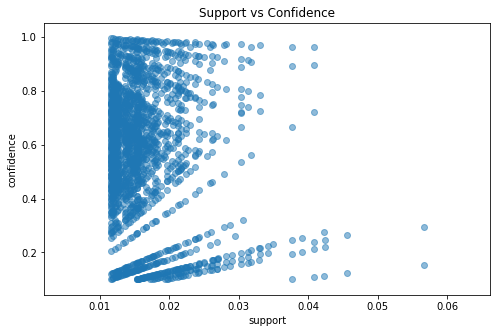

In [4]:
#https://medium.com/analytics-vidhya/association-analysis-in-python-2b955d0180c

plt.figure(figsize=(8, 5))
plt.scatter(association_rules['support'], association_rules['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()

the plot for support vs confidence shows that confidence have much greater values than support. confidence values are constatnt in all range. but support values are good from 0.01 to 0.03 range

### 9.2 Support vs Lift

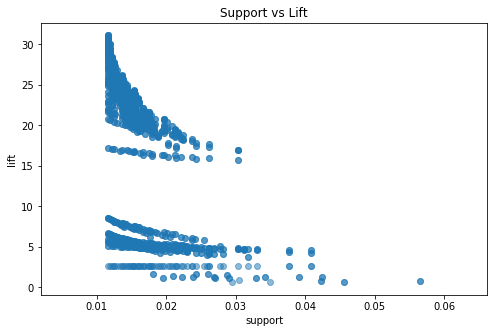

In [5]:
plt.figure(figsize=(8, 5))
plt.scatter(association_rules["support"], association_rules["lift"], alpha=0.5)
plt.xlabel("support")
plt.ylabel("lift")
plt.title("Support vs Lift")
plt.show()

support vs lift shows that as the support is increasing life values are decreasing

### 9.3 Lift vs Confidence

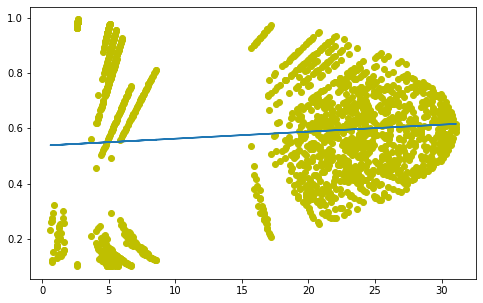

In [6]:
plt.figure(figsize=(8, 5))
fit = np.polyfit(association_rules["lift"], association_rules["confidence"], 1)
fit_fn = np.poly1d(fit)
plt.plot(association_rules["lift"], association_rules["confidence"], "yo", association_rules["lift"], 
         fit_fn(association_rules["lift"]))

Lift vs confidence plot is giving a leaf like structure . The plot is linear 

### 9.4 confidence plot

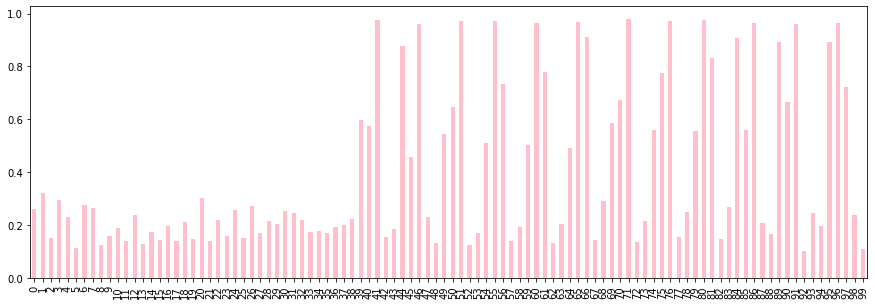

In [7]:
con = association_rules["confidence"][0:100]
#my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
plt.figure(figsize=(15, 5))
con.plot.bar(color='pink')

This is the confidence plot for 100 values of association rules which shows that the nearly half of the values of 
confidence is in good range of 0.6 to 1.0. This is a good result for applying model

### 9.5 confidence KDE plot

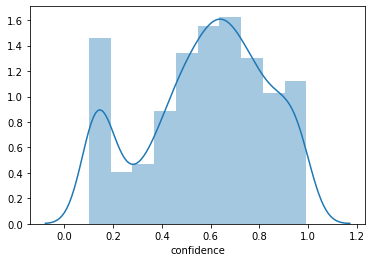

In [8]:
sns.distplot(association_rules['confidence'], bins=10, kde=True)

this is a kernal density estimation plot for confidence which represents the data using a continuous probability 
density curve.

### 9.6. Support Plot

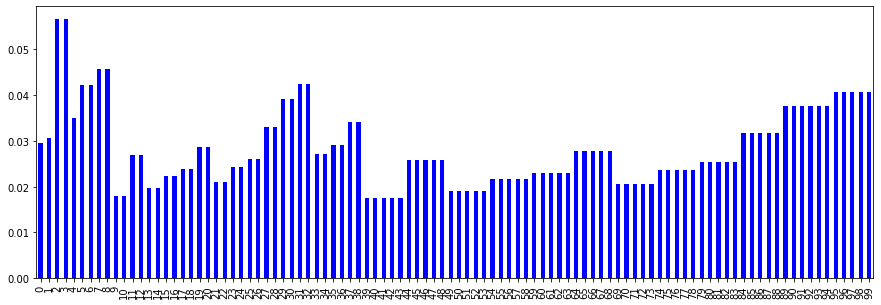

In [9]:
con = association_rules["support"][0:100]
#my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
plt.figure(figsize=(15, 5))
con.plot.bar(color='b')

This is the confidence plotf or the 100 values of association rules is difeerent than the plot for that support. 
The most of the values of support is lies between 0.02 to 0.04 range.

### 9.7 Support KDE plot

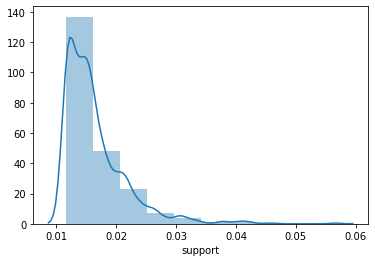

In [10]:
#https://towardsdatascience.com/introduction-to-data-visualization-in-python-89a54c97fbed
sns.distplot(association_rules['support'], bins=10, kde=True)

This is the KDE for support values which is skewed towards left.

### 9.8. Association rules correlation

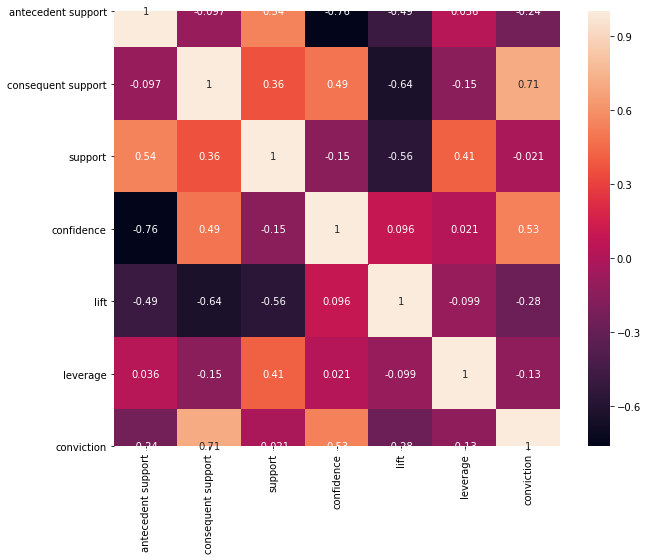

In [11]:
#https://towardsdatascience.com/introduction-to-data-visualization-in-python-89a54c97fbed
plt.figure(figsize=(10, 8))
association_rules = association_rules
sns.heatmap(association_rules.corr(), annot=True)

### 9.9. consequent support for each emotion

In [12]:
# finding unique antecendents emotion
frozensets = association_rules["antecedents"].values
aa = [list(x) for x in frozensets]

fset = association_rules["consequents"].values
cc = [list(x) for x in fset]

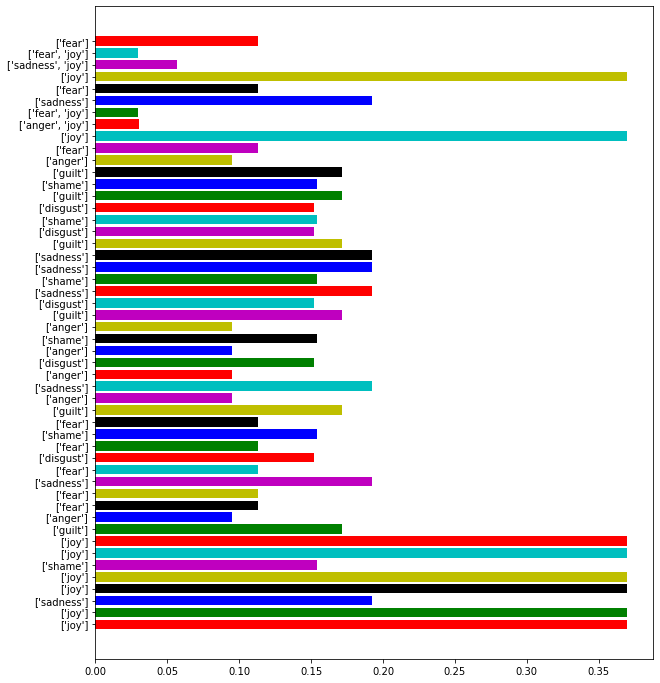

In [13]:
my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
c_features = cc[0:50]
c_support = association_rules["consequent support"][0:50].values
plt.figure(figsize=(10,12))
plt.barh(range(len(c_features)), c_support, color=my_colors, align='center')
plt.yticks(range(len(c_features)), [i for i in c_features])
plt.show()

This graph shows the consequent support for each emotion for 50 association rules . 

### 9.10 antecedent support for each emotion

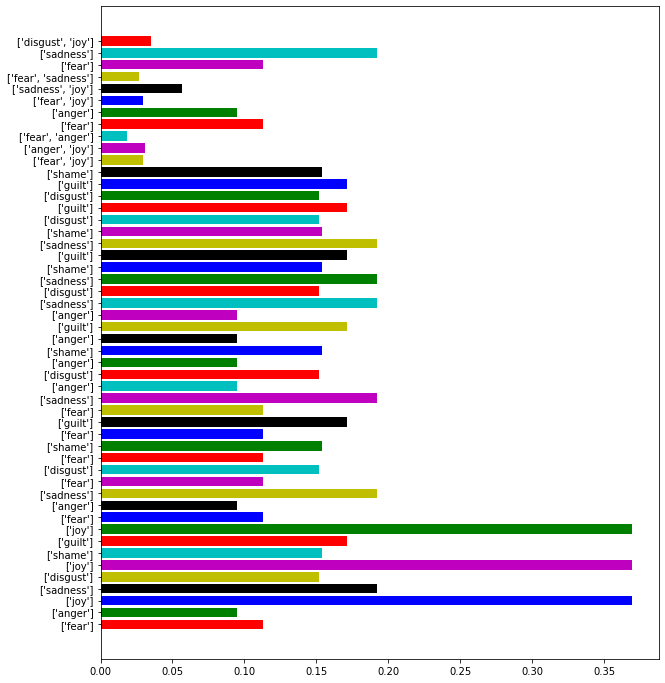

In [15]:
my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
a_features = aa[0:50]
a_support = association_rules["antecedent support"][0:50].values
plt.figure(figsize=(10,12))
plt.barh(range(len(a_features)), a_support, color=my_colors, align='center')
plt.yticks(range(len(a_features)), [i for i in a_features])
plt.show()

This graph shows the antecedent support for each emotion for 50 association rules . 

### 9.11 Network Graph

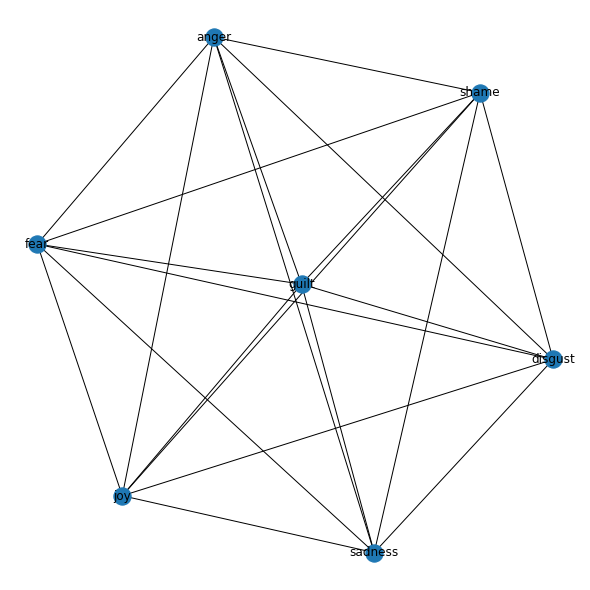

In [17]:
# libraries
import networkx as nx

association_rules = association_rules[0:1000]


frozensets = association_rules["antecedents"].values
aa = [list(x) for x in frozensets]
aa = [aa[x][0] for x in range(len(aa))]

fset = association_rules["consequents"].values
cc = [list(x) for x in fset]
cc = [cc[x][0] for x in range(len(cc))]
aa
# Build a dataframe with 4 connections
df = pd.DataFrame({ 'from':aa, 'to':cc})
#print(df)

# Build your graph
G=nx.from_pandas_edgelist(df, 'from', 'to')
 
# Plot it
plt.figure(figsize=(8,8))
nx.draw(G, with_labels=True)
plt.show()


This network graph shows the relationship of emotions form association rules. This is representation of 1000 association rules only. 